In [1]:
import os
import re
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from keras import initializers, regularizers, constraints
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.models import Sequential, load_model, Model
from keras.layers import (
    Dense,
    Dropout,
    Activation,
    MaxPooling1D,
    Flatten,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    BatchNormalization,
    CuDNNGRU,
    LSTM,
    Bidirectional,
    Input,
    concatenate,
)
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
from keras import backend as K
from numpy import random
import gensim

In [2]:
df = pd.read_csv('reviewContent+metadataBalanced.csv')

In [3]:
df=df.dropna() 

In [4]:
df

,user_id,prod_id,rating,label,date,text_
0,5044,0,1,0,11/16/2014,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,1,0,9/8/2014,This was the worst experience I've ever had a ...
2,5046,0,3,0,10/6/2013,This is located on the site of the old Spruce ...
3,5047,0,5,0,11/30/2014,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,5,0,8/28/2014,I love Toast! The food choices are fantastic -...
...,...,...,...,...,...,...
160927,265253,5041,5,0,11/15/2011,Great local lounge spot! After work and regula...
160928,265316,5042,5,0,12/24/2014,I have been to this place for the third time i...
160929,62901,5043,1,0,8/4/2011,Horrible service. I saw a customer accidentall...
160930,201246,5043,2,0,4/14/2013,Its your standard late-night drunk filled coll...


In [5]:
# Assuming 'text_' column contains the reviews
max_review_length = df['text_'].apply(len).max()
min_review_length = df['text_'].apply(len).min()

print(f"Maximum Review Length: {max_review_length}")
print(f"Minimum Review Length: {min_review_length}")

Maximum Review Length: 4995
Minimum Review Length: 1


In [6]:
# Assuming 'text_' column contains the reviews
reviews_length_one = df[df['text_'].apply(len) == 1]['text_']

print("Reviews with Length 1:")
print(reviews_length_one)

Reviews with Length 1:
521       -
19723     a
21940     I
24340     !
43114     .
44761     X
78921     .
88653     .
93034     .
96955     f
101671    a
101827    N
102182    .
124426    5
143975    .
147377    .
153123    ?
Name: text_, dtype: object


In [5]:
df.describe()


,user_id,prod_id,rating,label
count,160932.000000,160932.000000,160932.000000,160932.000000
mean,82018.298940,1727.836900,3.834868,0.500000
std,74370.033461,1559.997545,1.289868,0.500002
min,5044.000000,0.000000,1.000000,0.000000
25%,23998.750000,400.000000,3.000000,0.000000
50%,51973.500000,963.000000,4.000000,0.500000
75%,131655.250000,3122.000000,5.000000,1.000000
max,265319.000000,5043.000000,5.000000,1.000000


In [6]:
df_no_meta = df.drop(["user_id", "prod_id","date","rating"], axis=1)


In [7]:
df_no_meta1 =df_no_meta.sample(frac=1,random_state=1)

In [8]:
df_no_meta1.head()

,label,text_
96371,0,Best Italian shop in the area. I am a NYC tran...
103402,0,Have been going here for years. Food is always...
160285,0,I was expecting more from this place. I only e...
99317,0,I got take out food here recently and was plea...
132540,1,I've been going here since high school and to ...


In [9]:

label_encoder = preprocessing.LabelEncoder() 

df_no_meta1['label']= label_encoder.fit_transform(df_no_meta1['label']) 

df_no_meta1['label'].unique() 

array([0, 1], dtype=int64)

In [10]:
df_no_meta1

,label,text_
96371,0,Best Italian shop in the area. I am a NYC tran...
103402,0,Have been going here for years. Food is always...
160285,0,I was expecting more from this place. I only e...
99317,0,I got take out food here recently and was plea...
132540,1,I've been going here since high school and to ...
...,...,...
73349,1,The food is so fresh! Love it!
109259,0,More than a sports bar. Good food and service.
50057,1,One of those restaurants where you truly feel ...
5192,1,This place is cute! I went here long time ago....


In [11]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

In [12]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [13]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_data(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text
    
df_no_meta1['text_'] = df_no_meta1['text_'].apply(clean_data)

c:\Users\prems\anaconda3\envs\swm\lib\site-packages\ipykernel_launcher.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  # This is added back by InteractiveShellApp.init_path()


In [14]:
df_no_meta1

,label,text_
96371,0,best italian shop in the area i am a nyc trans...
103402,0,have been going here for years food is always ...
160285,0,i was expecting more from this place i only ex...
99317,0,i got take out food here recently and was plea...
132540,1,i have been going here since high school and t...
...,...,...
73349,1,the food is so fresh ! love it !
109259,0,more than a sports bar good food and service
50057,1,one of those restaurants where you truly feel ...
5192,1,this place is cute ! i went here long time ago...


In [15]:
X = df_no_meta1.text_
y = df_no_meta1.label

In [16]:
X = X.map(lambda a: clean_data(a))


In [17]:
train, test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=1)

In [18]:
tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)

In [19]:
tokenizer.fit_on_texts(X)


In [20]:
x_train = tokenizer.texts_to_sequences(train)

In [21]:
x_test = tokenizer.texts_to_sequences(test)

In [22]:
word_index = tokenizer.word_index

In [23]:
X = tokenizer.texts_to_sequences(X)

In [24]:
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

Vocab size: 87778
Longest comment size: 995
Average comment size: 105.61192304824398
Stdev of comment size: 102.15048849183476
Max comment size: 412


In [25]:
processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

In [26]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [27]:
processed_pre_x_train = pad_sequences(x_train, maxlen=max_len)
processed_pre_x_test = pad_sequences(x_test, maxlen=max_len)

In [28]:
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)


x_train shape: (128745, 412)
x_test shape: (32187, 412)


In [29]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [30]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [31]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [32]:
def get_model():
    review_input = Input(shape=(max_len,), dtype='int32')
    review_input_post = Input(shape=(max_len,), dtype='int32')

    x1 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input)
    x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Attention(max_len)(x1)

    x2 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input_post)
    x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Attention(max_len)(x2)

    x = concatenate([x1, x2])
    x = Dense(50, activation='relu')(x)
    x= Dropout(0.2)(x)
    x = BatchNormalization()(x)
    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[review_input, review_input_post], outputs=preds)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
K._get_available_gpus()

['/device:GPU:0']

In [34]:
model = get_model()


In [35]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 412)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 412)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 412, 100)     8777900     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 412, 100)     8777900     input_2[0][0]                    
______________________________________________________________________________________________

In [36]:
from keras.callbacks import ModelCheckpoint


In [37]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [38]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=10)

In [39]:
history = model.fit([processed_x_train,processed_pre_x_train],y_train, validation_data=([processed_x_test,processed_pre_x_test],y_test), epochs=10,batch_size=32,callbacks=[early_stopping_monitor],verbose=1)


Epoch 1/10
4024/4024 [==============================] - 459s 112ms/step - loss: 0.5726 - accuracy: 0.7000 - val_loss: 0.5263 - val_accuracy: 0.7360
Epoch 2/10
4024/4024 [==============================] - 448s 111ms/step - loss: 0.4699 - accuracy: 0.7749 - val_loss: 0.5217 - val_accuracy: 0.7391
Epoch 3/10
4024/4024 [==============================] - 445s 111ms/step - loss: 0.4015 - accuracy: 0.8156 - val_loss: 0.5569 - val_accuracy: 0.7222
Epoch 4/10
4024/4024 [==============================] - 448s 111ms/step - loss: 0.3447 - accuracy: 0.8462 - val_loss: 0.6245 - val_accuracy: 0.7207
Epoch 5/10
4024/4024 [==============================] - 457s 114ms/step - loss: 0.2907 - accuracy: 0.8713 - val_loss: 0.7079 - val_accuracy: 0.7120
Epoch 6/10
4024/4024 [==============================] - 438s 109ms/step - loss: 0.2430 - accuracy: 0.8948 - val_loss: 0.8051 - val_accuracy: 0.7123
Epoch 7/10
4024/4024 [==============================] - 430s 107ms/step - loss: 0.2038 - accuracy: 0.9116 - val_

In [40]:
model.evaluate([processed_x_test,processed_pre_x_test],y_test)


1006/1006 [==============================] - 47s 47ms/step - loss: 1.2154 - accuracy: 0.7023


[1.2153692245483398, 0.7023021578788757]

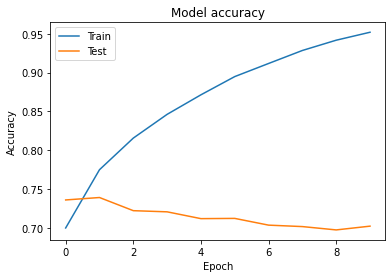

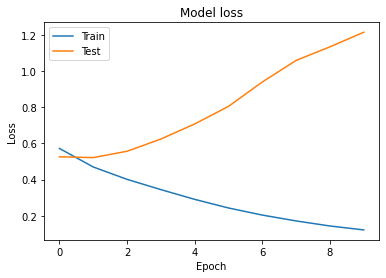

In [42]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
# Assuming y_pred is the predicted labels from your model
y_pred = model.predict([processed_x_test, processed_pre_x_test])
y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming binary classification, adjust threshold if needed



In [44]:
from sklearn.metrics import classification_report

# Assuming y_true_binary and y_pred_binary as defined earlier
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71     16093
           1       0.72      0.66      0.69     16094

    accuracy                           0.70     32187
   macro avg       0.70      0.70      0.70     32187
weighted avg       0.70      0.70      0.70     32187

